In [23]:
import kornia
import matplotlib.pyplot as plt
import torch
import cv2
import numpy as np
import sys
import statistics


In [30]:
def MySeamCarving(image, height_new, width_new):
    image_b, image_c, image_h, image_w = image.shape
    
    loop_count_h = 0
    loop_count_w = 0
    
    loop_count_h = abs(image_h - height_new)
    loop_count_w = abs(image_w - width_new)

    if(loop_count_h > 0):
        image = torch.transpose(image, 2, 3)
        loop = loop_count_h
    else:
        loop = loop_count_w

    while(loop>0):
        image = CarvingHelper(image)
        loop = loop - 1

    if(abs(image_h - height_new) >0):
        image = torch.transpose(image, 2, 3)
    return image


In [31]:
#For each color channel, 
#the energy is calculated by adding the absolute value of the gradient in the x direction 
#to the absolute value of the gradient in the y direction. 
#The energy for all color channels is summed into one 2D image to create the energy map.

def CarvingHelper(img_rgb):
    if(torch.is_tensor(img_rgb) != True):
        img_rgb = torch.from_numpy(img_rgb)

    sobels = kornia.filters.SpatialGradient()(img_rgb)
    sobelx = sobels[:, :, 0]
    sobely = sobels[:, :, 1]
    d_x = torch.pow(sobelx,2)
    d_y = torch.pow(sobely,2)
    grad_mag = torch.sqrt(d_x + d_y)
    
    # We sum the energies in the red, green, and blue channels
    energy_map = grad_mag[:,0,:,:] + grad_mag[:,1,:,:] + grad_mag[:,2,:,:]
    
    M = torch.zeros_like(energy_map)
    M[0,:] = energy_map[0,:]
    b,row,col = M.size()
    
    j=0
    for i in range(1,row):
        for j in range(0,col):
            if(j>0 and j<col-1):
                M[:,i,j] = min(M[:,i-1,j-1], M[:,i-1,j], M[:,i-1,j+1]) + energy_map[:,i,j]
            elif(j==0):
                M[:,i,j] = min(M[:,i-1,j], M[:,i-1,j+1]) + energy_map[:,i,j]
            elif(j>=col-1):
                M[:,i,j] = min(M[:,i-1,j-1], M[:,i-1,j]) + energy_map[:,i,j]

    i=row-1
    j=0
    b,c,row,col = img_rgb.size()
    new_image = torch.zeros(b,c,row,col+1)
    
    for i in range(row-1, -1, -1):
        if(i==row-1):
            low_energy_pixel = min(M[:,i,:])
            j = torch.argmin(low_energy_pixel)
            v1 = img_rgb[:,:,i,j-1]
            v2 = img_rgb[:,:,i,j+1]
            avg = (v1+v2)
            new_image[:,:,i,0:j] = img_rgb[:,:,i,0:j]
            new_image[:,:,i,j] = avg
            new_image[:,:,i,j+1:] = img_rgb[:,:,i,j:]        
        else:
            if(j==0):
                low_energy_pixel = min(M[:,i,j], M[:,i,j+1])
                if(low_energy_pixel == M[:,i,j+1]):
                    j = j+1
                #avg = torch.mean(img_rgb[:,:,i,j],img_rgb[:,:,i,j+1])
                v1 = img_rgb[:,:,i,j]
                v2 = img_rgb[:,:,i,j+1]
                avg = (v1+v2)/2
                new_image[:,:,i,0:j] = img_rgb[:,:,i,0:j]
                new_image[:,:,i,j] = avg
                new_image[:,:,i,j+1:] = img_rgb[:,:,i,j:]
            elif(j==col-1):
                low_energy_pixel = min(M[:,i,j-1], M[:,i,j])
                if(low_energy_pixel == M[:,i,j-1]):
                    j = j-1
                #avg = torch.mean(img_rgb[:,:,i,j-1],img_rgb[:,:,i,j])
                v1 = img_rgb[:,:,i,j-1]
                v2 = img_rgb[:,:,i,j]
                avg = (v1+v2)/2
                new_image[:,:,i,0:j] = img_rgb[:,:,i,0:j]
                new_image[:,:,i,j] = avg
                new_image[:,:,i,j+1:] = img_rgb[:,:,i,j:]
            else:
                low_energy_pixel = min(M[:,i,j-1], M[:,i,j], M[:,i,j+1])
                if(low_energy_pixel == M[:,i,j-1]):
                    j = j-1
                elif(low_energy_pixel == M[:,i,j+1]):
                    j = j+1
                #avg = torch.mean(img_rgb[:,:,i,j-1],img_rgb[:,:,i,j+1])
                v1 = img_rgb[:,:,i,j-1]
                v2 = img_rgb[:,:,i,j+1]
                avg = (v1+v2)/2
                new_image[:,:,i,0:j] = img_rgb[:,:,i,0:j]
                new_image[:,:,i,j] = avg
                new_image[:,:,i,j+1:] = img_rgb[:,:,i,j:]
    
    return new_image

In [34]:

x_rgb: torch.Tensor = kornia.io.load_image("York.jpg", kornia.io.ImageLoadType.RGB32)[None, ...]  # BxCxHxW Batch Channel Height Width
x_rgb2: torch.Tensor = kornia.io.load_image("duck.jpeg", kornia.io.ImageLoadType.RGB32)[None, ...]  # BxCxHxW Batch Channel Height Width

height = 250
width = 200
img_array = kornia.tensor_to_image(x_rgb2)

finalImg = MySeamCarving(x_rgb2, height, width)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


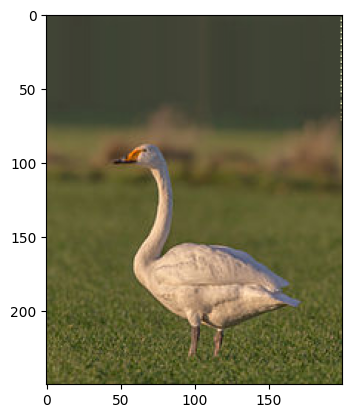

In [35]:

img_arraya = kornia.tensor_to_image(finalImg)
open_cv_image = np.array(img_arraya) 
plt.imshow(img_arraya)